# Chasing the Overton Window

This is one of the Jupyter notebooks I used in my preparation of *[Probably Overthinking It: How to Use Data to Answer Questions, Avoid Statistical Traps, and Make Better Decisions](https://greenteapress.com/wp/probably-overthinking-it)*, University of Chicago Press, 2023.

Before you read these notebooks, please keep in mind:

* There is some explanatory text here, but some of the examples will not make sense until you have read the corresponding chapter in the book.

* While preparing these notebooks, I made some changes to improve the readability of the code. There might be small differences between what appears in the book and what you get when you run the code.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/notebooks/overton.ipynb).

In [1]:
# Install empiricaldist if we don't already have it

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [2]:
# download utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download("https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the random seed so we get the same results every time
np.random.seed(17)

In [4]:
from utils import (
    set_pyplot_params,
    underride,
    decorate,
    decorate_table,
    prepare_yvar,
    run_subgroups,
    chunk_series,
    make_table,
    visualize_table,
    label_table,
    label_table_left,
    make_lowess,
    plot_series_lowess,
)

# set_pyplot_params()

# Chasing the Overton Window

There's a famous (but unattributable) quote about liberals and conservatives that goes something like this:

> If you are not a liberal at 25, you have no heart. If you are not a conservative at 35, you have no brain.

It turns out that there is some truth to this.
People under 30 are actually more likely to consider themselves liberal, and people over 30 are more likely to consider themselves conservative.
And it's not just what they call themselves; the views of older people are more conservative, on average, than the views of younger people.

However, as we saw in the previous chapter, just because older people hold a particular view, that doesn't mean people adopt that view as they get older.
In fact, in most birth cohorts, people get more liberal as they age.
As you probably recognize by now, this is an example of Simpson's paradox.

But Simpson's paradox doesn't explain why people *consider* themselves more conservative even as they are becoming more liberal.
To understand that, we'll need two ideas from the previous chapter: age-period-cohort analysis and the Overton window.

## Old Conservatives, Young Liberals?

To recap, here are the phenomena I will try to explain:

* People are more likely to identify as conservative as they get older.

* And older people hold more conservative views, on average.

* However, as people get older, their views do not become more conservative.

In other words, people think they are becoming more conservative, but they are not.
First, let me show that each of these claims is true; then I'll explain why.

To demonstrate the first claim, I'll use responses to the following question:

> I'm going to show you a seven-point scale on which the political views that people might hold are arranged from extremely liberal--point 1--to extremely conservative--point 7. Where would you place yourself on this scale?

The points on the scale are Extremely liberal, Liberal, and Slightly liberal; Moderate;	Slightly conservative, Conservative, and Extremely conservative.

I'll lump the first three points into "Liberal" and the last three into "Conservative", which makes the number of groups manageable and, it turns out, roughly equal in size.
The following figure shows the percentage of respondents who consider themselves to be in each of these groups, as a function of age.

In [5]:
download("https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/master/gss_pacs_resampled.hdf")

In [6]:
filename = "gss_pacs_resampled.hdf"
gss = pd.read_hdf(filename, "gss0")
gss.shape

(72390, 204)

In [7]:
bins = np.arange(1889, 2011, 10)
labels = bins[:-1] + 1

gss["cohort10"] = pd.cut(gss["cohort"], bins, labels=labels).astype(float)
gss["cohort10"].value_counts().sort_index()

cohort10
1890.0      455
1900.0     1717
1910.0     3663
1920.0     5959
1930.0     7063
1940.0    10983
1950.0    14448
1960.0    11303
1970.0     7851
1980.0     5062
1990.0     2590
2000.0      524
Name: count, dtype: int64

In [8]:
gss.dropna(subset=["cohort10"], inplace=True)
gss["cohort10"] = gss["cohort10"].astype(int)

In [9]:
gss["polviews"].value_counts()

polviews
4.0    23893
5.0     9754
6.0     9484
3.0     7749
2.0     7231
7.0     2097
1.0     2063
Name: count, dtype: int64

In [10]:
recode_polviews = {
    1: "Liberal",
    2: "Liberal",
    3: "Liberal",
    4: "Moderate",
    5: "Conservative",
    6: "Conservative",
    7: "Conservative",
}
gss["polviews3"] = gss["polviews"].replace(recode_polviews)

In [11]:
polview_names = ["Liberal", "Moderate", "Conservative"]

muted = sns.color_palette("muted", 5)
polview_map = dict(zip(polview_names, [muted[0], muted[4], muted[3]]))
marker_map = dict(zip(polview_names, ["o", "^", "s"]))
line_map = dict(zip(polview_names, [":", "-.", "--"]))

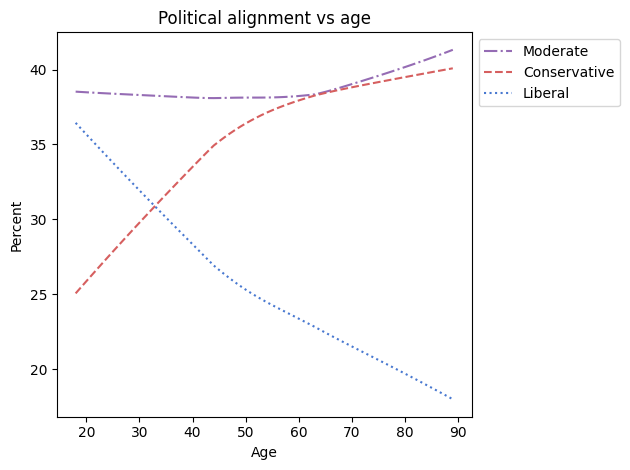

In [12]:
xtab = pd.crosstab(gss["age"], gss["polviews3"], normalize="index") * 100

columns = ["Moderate", "Conservative", "Liberal"]
options = dict(frac=0.75, plot_series=False)
for column in columns:
    plot_series_lowess(
        xtab[column], ls=line_map[column], color=polview_map[column], **options
    )

decorate(
    xlabel="Age",
    ylabel="Percent",
    title="Political alignment vs age",
    loc="center right",
)
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.savefig("overton1.jpg", dpi=600)

At every age, the largest group of respondents describe themselves as moderate.
However, in accordance with the unattributable quip, people under thirty are more likely to consider themselves liberal, and people over thirty are more likely to consider themselves conservative.

Within most birth cohorts, the pattern is the same: as people get older, they are more likely to identify as conservative.
The following figure shows the percentage of people who identify as conservative as a function of age, grouped by decade of birth.

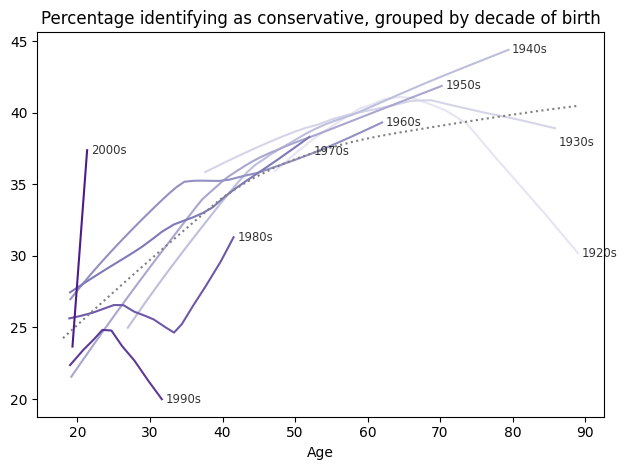

In [13]:
xvarname = "age"
yvarname = "polviews3"
gvarname = "cohort10"
yvalue = "Conservative"

table = make_table(gss, xvarname, yvarname, gvarname, yvalue)
del table[1900]
del table[1910]
series = chunk_series(gss, xvarname) * 100

visualize_table(series, table, frac=0.8)

nudge = {"1970s": -1, "1930s": -1}
label_table(table, nudge, frac=0.8)

decorate(
    xlabel="Age",
    label="Percent",
    title="Percentage identifying as conservative, grouped by decade of birth",
    legend=False,
)
plt.savefig("overton2.jpg", dpi=600)

There is evidence here for an age effect; in many groups there is a notable increase around age 30 and a leveling off after age 40.
The most recent cohorts in the dataset, people born in the 1980s and 1990s, might be an exception; so far, they show no trend toward conservative identity.
But the oldest of them were surveyed in their 30s, so it might be too early to tell.

## What does "conservative" mean?

Now, to test the second claim -- that older people hold more conservative views -- we have to figure out what conservative views are.
To do that, I searched for questions in the GSS with the biggest differences between the responses of self-described liberals and conservatives.
From those, I curated a list of fifteen questions that cover a diverse set of topics, with preference for questions that were asked most frequently over the years of the survey.

The topics that made the list are not surprising. They include economic issues like public spending on welfare and the environment; policy issues like the legality of guns, drugs, and pornography; as well as questions related to sex education and prayer in schools, capital punishment, assisted suicide, and (of course) abortion.
The list also includes three of the questions we looked at in the previous chapter, related to open housing laws, women in politics, and homosexuality.

For the current purpose, we are not concerned with the wording of the questions; we only need to know that liberals and conservatives give different answers.
But if you are curious, the list of questions is at the end of this chapter.

In [14]:
varnames = [
    "abany",
    "abdefect",
    "abhlth",
    "abnomore",
    "abpoor",
    "abrape",
    "absingle",
    "affrmact",
    "bible",
    "cappun",
    "colath",
    "colcom",
    "colhomo",
    "colmil",
    "colmslm",
    "colrac",
    "compuse",
    "conarmy",
    "conbus",
    "conclerg",
    "coneduc",
    "confed",
    "confinan",
    "conjudge",
    "conlabor",
    "conlegis",
    "conmedic",
    "conpress",
    "consci",
    "contv",
    "discaffm",
    "discaffw",
    "divlaw",
    "divorce",
    "fair",
    "fear",
    "fechld",
    "fefam",
    "fehire",
    "fejobaff",
    "fepol",
    "fepresch",
    "finrela",
    "fund",
    "god",
    "grass",
    "gunlaw",
    "hapmar",
    "happy",
    "health",
    "helpful",
    "homosex",
    "hunt",
    "letdie1",
    "libath",
    "libcom",
    "libhomo",
    "libmil",
    "libmslm",
    "librac",
    "life",
    "meovrwrk",
    "nataid",
    "natarms",
    "natchld",
    "natcity",
    "natcrime",
    "natdrug",
    "nateduc",
    "natenrgy",
    "natenvir",
    "natfare",
    "natheal",
    "natmass",
    "natpark",
    "natrace",
    "natroad",
    "natsci",
    "natsoc",
    "natspac",
    "pornlaw",
    "postlife",
    "pray",
    "prayer",
    "premarsx",
    "pres04",
    "pres08",
    "pres12",
    "racmar",
    "racopen",
    "racpres",
    "reborn",
    "relexp",
    "reliten",
    "relpersn",
    "satfin",
    "satjob",
    "savesoul",
    "sexeduc",
    "spanking",
    "spkath",
    "spkcom",
    "spkhomo",
    "spkmil",
    "spkmslm",
    "spkrac",
    "sprtprsn",
    "teensex",
    "trust",
    "union_",
    "xmarsex",
    "owngun",
    "pistol",
    "attend",
    "relactiv",
]

len(varnames)

115

In [15]:
import statsmodels.formula.api as smf


def find_questions():
    """Find the questions with the biggest differences.
    
    Run logistic regression vs polviews,
    controlling for year and cohort,
    and sort by the parameter of polviews.
    """
    res = []
    for varname in varnames:
        prepare_yvar(gss, varname)
        subset = gss.dropna(subset=[varname, "polviews"])
        formula = "y ~ year + cohort + polviews"
        results = smf.logit(formula, data=subset).fit(disp=False)
        param = results.params["polviews"]
        res.append((abs(param), varname, param))
    return sorted(res)


# find_questions()

In [16]:
# identify the responses considered conservative

convervative_values = {
    "abany": [2],
    "homosex": [1, 2, 3],
    "premarsx": [1, 2, 3],
    "prayer": [2],
    "natfare": [3],
    "grass": [2],
    "natenvir": [2, 3],  # about right or too much
    "divlaw": [2],
    "cappun": [1],
    "racopen": [1],
    "letdie1": [2],
    "fepol": [1],
    "gunlaw": [2],
    "sexeduc": [2],
    "pornlaw": [1],
}

len(convervative_values)

15

In [17]:
order = [
    "homosex",
    "cappun",
    "grass",
    "abany",
    "prayer",
    "premarsx",
    "divlaw",
    "natfare",
    "natenvir",
    "pornlaw",
    "racopen",
    "letdie1",
    "fepol",
    "gunlaw",
    "sexeduc",
]

In [18]:
questions = pd.DataFrame(dtype=float)

for varname in order:
    questions[varname] = gss[varname].isin(convervative_values[varname]).astype(float)
    null = gss[varname].isna()
    questions.loc[null, varname] = np.nan

questions.mean().sort_values()

sexeduc     0.123340
gunlaw      0.250037
fepol       0.282195
letdie1     0.314927
pornlaw     0.363665
racopen     0.375597
natenvir    0.379655
natfare     0.467340
divlaw      0.490939
premarsx    0.533950
abany       0.583890
prayer      0.589122
grass       0.677196
homosex     0.695584
cappun      0.700537
dtype: float64

In [19]:
# none of these questions were retired early

for varname in order:
    last = gss.dropna(subset=[varname])["year"].max()
    print(varname, last)

homosex 2022
cappun 2022
grass 2022
abany 2022
prayer 2022
premarsx 2022
divlaw 2018
natfare 2022
natenvir 2022
pornlaw 2022
racopen 2022
letdie1 2022
fepol 2022
gunlaw 2022
sexeduc 2022


In [20]:
augmented = pd.concat([questions, gss["polviews3"]], axis=1)
table = augmented.groupby("polviews3").mean().transpose() * 100
table

polviews3,Conservative,Liberal,Moderate
homosex,80.092662,52.337900,69.696157
cappun,79.086744,56.185338,72.306497
grass,75.236948,53.986284,67.425543
abany,69.427806,41.452613,58.497102
prayer,66.719078,43.253610,61.895926
premarsx,64.186184,38.025460,51.221477
divlaw,58.510374,38.257774,48.055576
natfare,57.672645,33.460116,47.237803
natenvir,48.662821,25.057568,37.155963
pornlaw,43.918968,24.732184,35.467433


In [21]:
(table["Conservative"] - table["Liberal"]).sort_values()

sexeduc     11.368680
fepol       11.857101
gunlaw      13.814068
racopen     14.445549
letdie1     14.743595
pornlaw     19.186783
divlaw      20.252600
grass       21.250664
cappun      22.901406
prayer      23.465467
natenvir    23.605254
natfare     24.212529
premarsx    26.160724
homosex     27.754762
abany       27.975193
dtype: float64

In [22]:
issue_dict = {
    "abany": "Abortion",
    "homosex": "Homosexuality",
    "premarsx": "Premarital sex",
    "prayer": "School prayer",
    "natfare": "Welfare spending",
    "grass": "Legal cannabis",
    "natenvir": "Environment",
    "divlaw": "Divorce",
    "cappun": "Capital punishment",
    "racopen": "Fair housing law",
    "letdie1": "Assisted suicide",
    "fepol": "Women in politics",
    "gunlaw": "Gun law",
    "sexeduc": "Sex education",
    "pornlaw": "Pornography",
}

issue_names = pd.Series(issue_dict)[order].values

For each question, I identified the responses more likely to be chosen by conservatives.
The following figure shows, for each question, the percentage of liberals, moderates, and conservatives who chose one of the conservative responses.

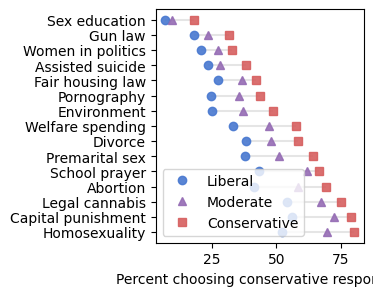

In [23]:
figwidth = 3.835
plt.figure(figsize=(figwidth, 0.8*figwidth))
plt.hlines(
    issue_names,
    table["Liberal"],
    table["Conservative"],
    color="gray",
    alpha=0.2,
)

for polviews, color in polview_map.items():
    x = table[polviews]
    marker = marker_map[polviews]
    plt.plot(x, issue_names, marker, color=color, alpha=0.9, label=polviews)

decorate(xlabel="Percent choosing conservative responses")
plt.savefig("overton3.jpg", dpi=600)

Not surprisingly, conservatives are more likely than liberals to choose conservative responses, and moderates are somewhere in the middle.
The differences between the groups range from 11 to 27 percentage points.

These results include respondents over the interval from 1973 to 2021, so they are not a snapshot of recent conditions.
Rather, they show the issues that have distinguished conservatives from liberals over the last 50 years.

Now let's see if it's true that older people hold more conservative views.
For each respondent, I computed the number of conservative responses they chose.

One difficulty is that not every respondent answered every question.
Some were surveyed before a particular question was added to the survey or after it was removed.
Also, in some years respondents were randomly assigned a "ballot" with subset of the questions.
Finally, a small percentage of respondents refuse to answer some questions, or say "I don't know".

To address this difficulty, I used a statistical model to estimate a degree of conservatism for each respondent, and to predict the number of conservative responses they would give if they were asked all fifteen questions.
To avoid extrapolating too far beyond the data, I selected only respondents who answered at least five of the fifteen questions, which is about 63,000 out of 68,000.

The following figure shows the average of these estimates, grouped by political alignment (conservative, moderate, or liberal) and plotted by age.

In [24]:
# some questions are "easier" than others; we can use the logit of the prevalence
# for each question to estimate its difficulty

from scipy.special import logit

means = pd.to_numeric(questions.mean())
difficulty = -logit(means)
difficulty

homosex    -0.826358
cappun     -0.849855
grass      -0.740913
abany      -0.338762
prayer     -0.360336
premarsx   -0.136011
divlaw      0.036247
natfare     0.130828
natenvir    0.491012
pornlaw     0.559490
racopen     0.508279
letdie1     0.777186
fepol       0.933600
gunlaw      1.098417
sexeduc     1.961172
dtype: float64

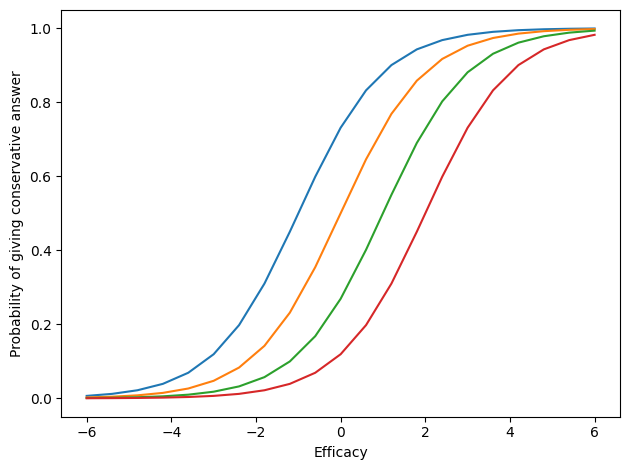

In [25]:
# each respondent has an "efficacy" that represents their propensity to give
# conservative answers

# the range of difficulties dictates the useful part of the range of efficacies;
# for example, if we sweep from -6 to 6, we see the complete range of probabilities
# for questions in the relevant range of difficulty


from scipy.special import expit

xs = np.linspace(-6, 6, 21)

for d in [-1, 0, 1, 2]:
    p = expit(xs - d)
    plt.plot(xs, p)

decorate(xlabel="Efficacy", ylabel="Probability of giving conservative answer")

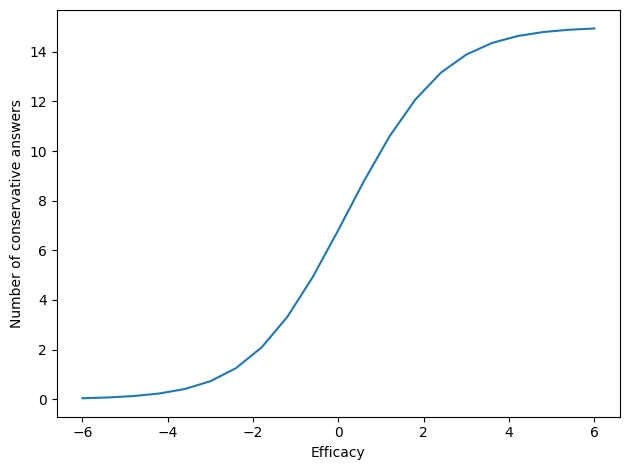

In [26]:
# if we make a mesh with one row for each efficacy and one column for each question,
# we can make a mapping from each efficacy to the number of conservative answers we
# expect from a person with each efficacy

X, D = np.meshgrid(xs, difficulty)
P = expit(X - D)
ns = P.sum(axis=0)
plt.plot(xs, ns)

decorate(xlabel="Efficacy", ylabel="Number of conservative answers")

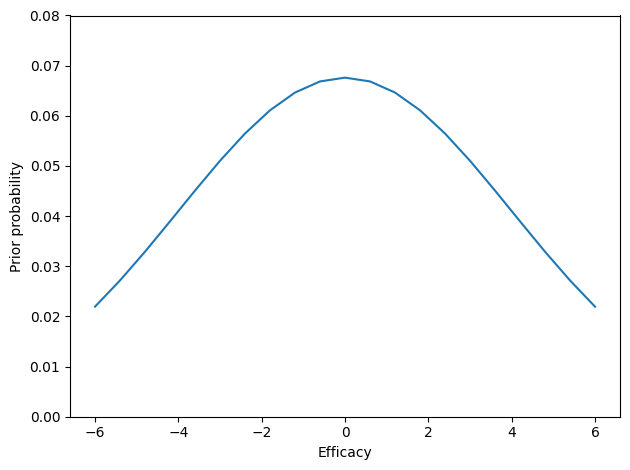

In [27]:
# as a prior for efficacy, I'll use a wide Gaussian, which represents
# a gentle bias toward the middle of the range

from scipy.stats import norm
from empiricaldist import Pmf

ys = norm.pdf(xs, 0, 4)
prior = Pmf(ys, xs)
prior.normalize()
prior.plot()
decorate(xlabel="Efficacy", ylabel="Prior probability", ylim=[0, 0.08])

In [28]:
# I'll use an arbitrary sample row to test the estimation process

row = questions.iloc[5000]
row

homosex     NaN
cappun      1.0
grass       0.0
abany       NaN
prayer      0.0
premarsx    1.0
divlaw      1.0
natfare     0.0
natenvir    1.0
pornlaw     0.0
racopen     1.0
letdie1     NaN
fepol       0.0
gunlaw      1.0
sexeduc     0.0
Name: 5034, dtype: float64

In [29]:
# compute the likelihood of true and false values
# one row per question
# one column per efficacy

X, D = np.meshgrid(xs, difficulty)
P = expit(X - D)
Q = 1 - P
Q.shape

(15, 21)

(7.746546988198355, 1.9404648754849896)

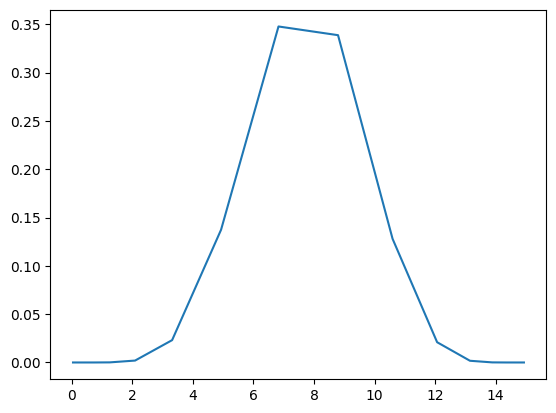

In [30]:
# here are the steps for the update

# compute the likelihoods of the conservative responses
index1 = np.nonzero(row.values == True)
like1 = P[index1]

# compute the likelihoods of the non-conservative responses
index2 = np.nonzero(row.values == False)
like2 = Q[index2]

like = np.vstack([like1, like2]).prod(axis=0)

# compute the normalized posterior distribution
posterior = Pmf(prior.values * like, ns)
posterior.normalize()
posterior.plot()
posterior.mean(), posterior.std()

In [31]:
def estimate_conservatism(row):
    """Compute the posterior distribution of conservatism.

    row: pd.Series of True, False, or NaN, one per question

    returns: posterior mean and std of estimated conservatism
    """
    index1 = np.nonzero(row.values == True)
    like1 = P[index1]

    index2 = np.nonzero(row.values == False)
    like2 = Q[index2]

    like = np.vstack([like1, like2]).prod(axis=0)

    posterior = Pmf(prior.values * like, ns)
    posterior.normalize()

    return posterior.mean(), posterior.std()

In [32]:
#%time res = questions.apply(estimate_conservatism, axis=1, result_type='expand')
# res.shape

In [33]:
# mean, std = np.transpose(res.values)

In [34]:
# to eliminate the for loop, we can compute the results for all respondents
# with a single 3-D array: one row for each respondent, one column for each question,
# one page for each hypothetical value of efficacy

n, m = questions.shape
size = n, m, len(xs)
res = np.empty(size)
res.shape

(71618, 15, 21)

In [35]:
# now we can fill the array with the likelihoods of conservative and non-conservative
# responses; where there's a NaN, we fill in all 1

a = questions.fillna(2).astype(int).values
ii, jj = np.nonzero(a == 0)
res[ii, jj, :] = Q[jj]
ii, jj = np.nonzero(a == 1)
res[ii, jj, :] = P[jj]
ii, jj = np.nonzero(a == 2)
res[ii, jj, :] = 1

In [36]:
# multiplying along the rows gives the likelihood of each row of responses,
# which we multiply by the prior probabilities

product = res.prod(axis=1) * prior.values
product.shape

(71618, 21)

In [37]:
# normalize the rows to get a posterior distribution for each respondent

posterior = product / product.sum(axis=1)[:, None]
posterior.shape

(71618, 21)

In [38]:
# compute the means of the posterior distributions

con = (posterior * ns).sum(axis=1)
con.shape

(71618,)

In [39]:
# np.allclose(con, mean)

In [40]:
# and the variances of the posterior distributions

deviations = ns - con[:, None]
var_con = (posterior * deviations**2).sum(axis=1)
std_con = np.sqrt(var_con)
std_con.shape

(71618,)

In [41]:
# np.allclose(np.sqrt(var), std)

<Axes: >

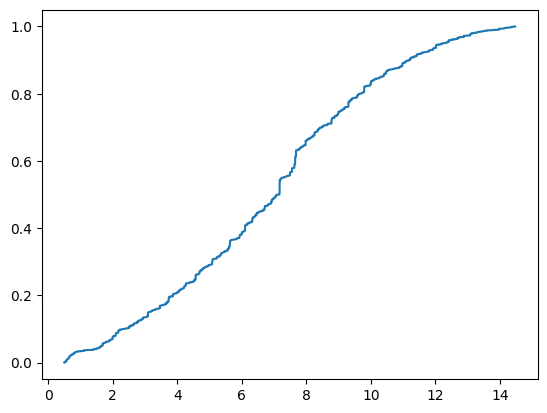

In [42]:
# the estimated values are roughly Gaussian

from empiricaldist import Cdf

Cdf.from_seq(con).plot()

<Axes: >

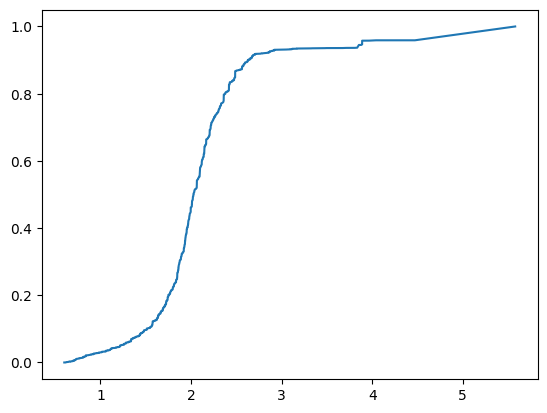

In [43]:
# the posterior standard deviations show that for more respondents we have
# enough data to estimate the number of conservative responses with std less than 3

Cdf.from_seq(std_con).plot()

In [44]:
answered = questions.notna().sum(axis=1)
np.percentile(answered, [10, 90])

array([ 5., 12.])

In [45]:
(answered >= 5).mean()

0.904283839258287

In [46]:
gss["conservatism"] = pd.Series(con, gss.index)
gss.loc[answered < 5, "conservatism"] = np.nan
gss["conservatism"].describe()

count    64763.000000
mean         6.833093
std          3.217315
min          0.494033
25%          4.524838
50%          6.838483
75%          9.302133
max         14.475336
Name: conservatism, dtype: float64

In [47]:
series = gss.groupby("age")["conservatism"].mean()
make_lowess(series)

18.0    5.550790
19.0    5.599471
20.0    5.648384
21.0    5.697544
22.0    5.746937
          ...   
85.0    8.524548
86.0    8.562649
87.0    8.600669
88.0    8.638592
89.0    8.676410
Length: 72, dtype: float64

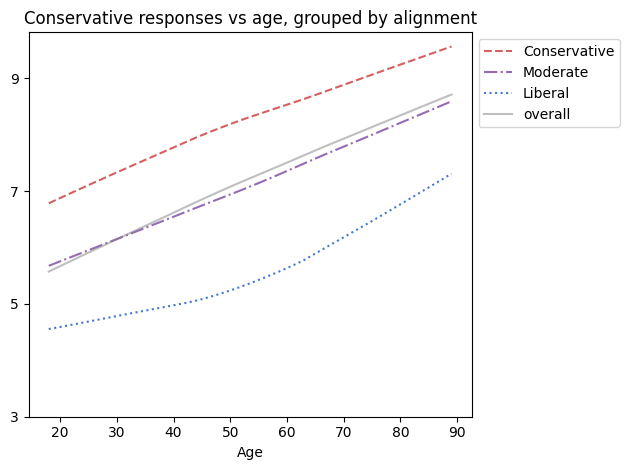

In [48]:
table = gss.pivot_table(index="age", columns="polviews3", values="conservatism")

columns = ["Conservative", "Moderate", "Liberal"]
for column in columns:
    plot_series_lowess(
        table[column], ls=line_map[column], color=polview_map[column], **options
    )

plot_series_lowess(series, ls="-", color="gray", alpha=0.5, label="overall")

decorate(
    xlabel="Age",
    title="Conservative responses vs age, grouped by alignment",
    loc="lower right",
)
plt.yticks([3, 5, 7, 9])
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.savefig("overton4.jpg", dpi=600)

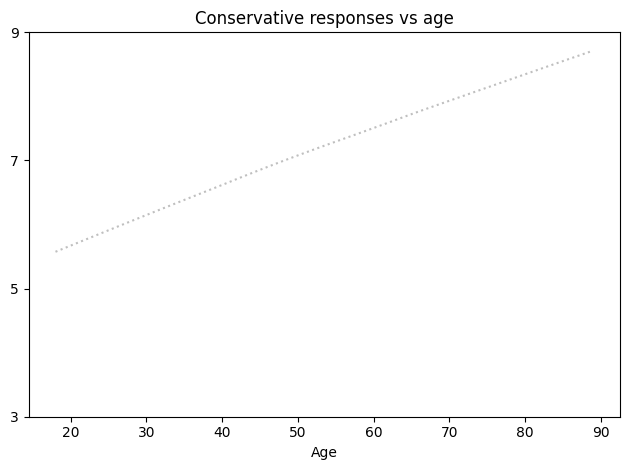

In [49]:
plot_series_lowess(series, ls=":", color="gray", alpha=0.5, label="")

decorate(
    xlabel="Age",
    title="Conservative responses vs age",
    loc="lower right",
)
plt.yticks([3, 5, 7, 9])
plt.tight_layout()
plt.savefig("overton4.jpg", dpi=600)

The gray line shows the overall trend: older people hold more conservative views.
At age 18, the average number of conservative responses is 5.7 out of 15; at age 89, it is 8.7.
The lines for conservatives, moderates, and liberals show that the trend within the groups is the same as the trend between the groups.

However, as we have seen before, that doesn't mean that people get more conservative as they get older.
The following figure shows conservatism as a function of age, again, but with respondents grouped by decade of birth.

In [50]:
xvarname = "age"
yvarname = "conservatism"
gvarname = "cohort10"
yvalue = "continuous"

params = run_subgroups(gss, xvarname, yvarname, gvarname, yvalue)
params

,param,pvalue,stderr,conf_inf
all,0.045242,0.000000e+00,0.000713,"[0.043844088801497254, 0.04663908798590554]"
1890,-0.008260,7.771757e-01,0.029166,"[-0.06561936249845171, 0.04909885532839052]"
1900,0.014340,1.608961e-01,0.010223,"[-0.005712165422156312, 0.03439157506483011]"
1910,-0.008070,1.634818e-01,0.005790,"[-0.01942248209664968, 0.0032824724283858926]"
1920,-0.005488,1.383686e-01,0.003703,"[-0.012748084620149699, 0.0017711709097031963]"
1930,-0.018045,1.637154e-10,0.002819,"[-0.023570738301045863, -0.012520190611341795]"
1940,-0.007827,5.073957e-04,0.002250,"[-0.012238273454453977, -0.0034156368123330286]"
1950,-0.013393,8.792671e-13,0.001872,"[-0.017061860213908552, -0.009724006178443111]"
1960,-0.024558,1.649682e-24,0.002397,"[-0.029256611867895754, -0.019858586277253714]"
1970,-0.014033,2.718640e-04,0.003852,"[-0.02158421514632847, -0.006480801212967946]"


In [51]:
def summarize_params(params):
    """Print a summary of the number of groups
    with positive or negative slope.
    """
    print("Number of groups", len(params) - 1)
    sig = params.iloc[1:]["pvalue"] < 0.02
    neg = (params.iloc[1:]["param"] < 0) & sig
    pos = (params.iloc[1:]["param"] > 0) & sig
    print("# neg, #pos", neg.sum(), pos.sum())

In [52]:
summarize_params(params)

Number of groups 12
# neg, #pos 7 0


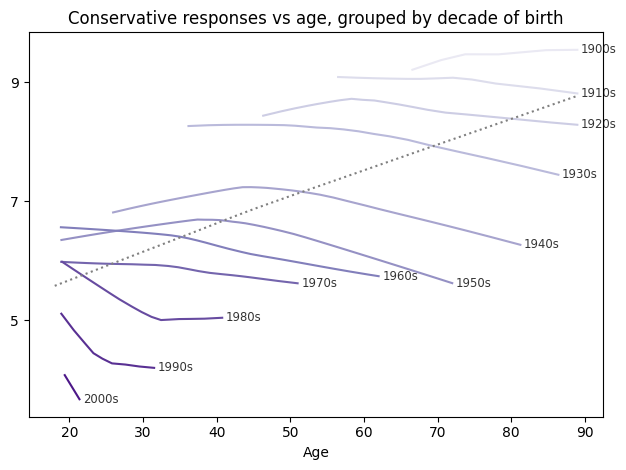

In [53]:
table = make_table(gss, xvarname, yvarname, gvarname, yvalue)
series = chunk_series(gss, xvarname)

visualize_table(series, table, frac=0.8)
label_table(table, frac=0.8)

decorate(
    xlabel="Age",
    title="Conservative responses vs age, grouped by decade of birth",
    legend=False,
)
plt.yticks([5, 7, 9])
plt.savefig("overton5.jpg", dpi=600)

Almost every birth cohort became more liberal with age.
Some of the oldest cohorts were essentially unchanged.
None became more conservative.

In several cohorts we see a similar pattern -- a relatively fast increase followed by a slower decrease -- but the inflection point does not appear at the same age in different groups, so that does not suggest an age effect.

## How Can This Be?

By now you have probably figured out that part of the explanation is Simpson's paradox.
Older respondents are more likely to come from earlier generations, which were more conservative; younger respondents are more likely to come from recent generations, which are more liberal.

That explains why older people are more conservative, but people don't become more conservative as they age.
The apparent increase is a cohort effect, not an age effect.

But that doesn't explain why people are more likely to *consider* themselves conservative even as, on average, they become more liberal.
The explanation I propose has three pieces:

* First, the center of public opinion has moved toward liberalism over the last 50 years, primarily due to a cohort effect and secondarily due to a period effect.

* Second, "liberal" and "conservative" are relative terms. If someone's views are left of center, they are more likely to call themselves liberal. If their views are right of center, they are more likely to call themselves conservative. Either way, the label they choose depends on where they think the center is.

* Third, over the last 50 years both liberals and conservatives have become more liberal. As a result, conservatives are about as liberal now as liberals were in the 1970s.

Putting these pieces together, the consequence is that someone considered liberal in the 1970s would be considered conservative in the 2010s.
So someone considered liberal in their youth, and who becomes more liberal over time, might nevertheless be considered -- and identify as -- more conservative as they age.

Let's consider these points one at a time.

## The Center Does Not Hold

In the last 50 years, the Overton window has shifted toward liberalism.
The following figure shows how the answers to my fifteen questions have changed over time.
Each circle represents the actual average for a group of 2000 respondents.
The dotted line shows a smooth curve fitted to the data.

In [54]:
xvarname = "year"
yvarname = "conservatism"
gvarname = "cohort10"
yvalue = "continuous"

prepare_yvar(gss, yvarname, yvalue)
series_conservatism = chunk_series(gss, "year", size=2000)
smooth = make_lowess(series_conservatism)
smooth.head()

1973.2640    7.964162
1974.5275    7.936313
1975.8320    7.905931
1977.2845    7.870442
1979.0470    7.825815
dtype: float64

In [55]:
smooth.tail()

2018.0000    5.447441
2020.5605    5.217721
2021.0435    5.174298
2022.0000    5.088276
2022.0000    5.088276
dtype: float64

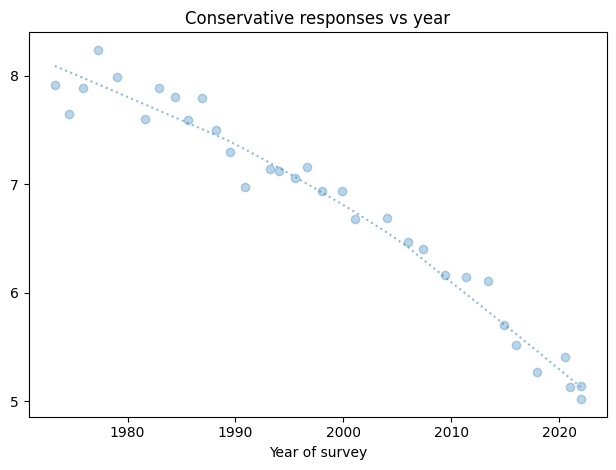

In [56]:
plot_series_lowess(
    series_conservatism, plot_series=True, ls=":", color="C0", alpha=0.5, label=""
)
decorate(
    xlabel="Year of survey", title="Conservative responses vs year"
)
plt.yticks([5, 6, 7, 8])
plt.savefig("overton6.jpg", dpi=600)

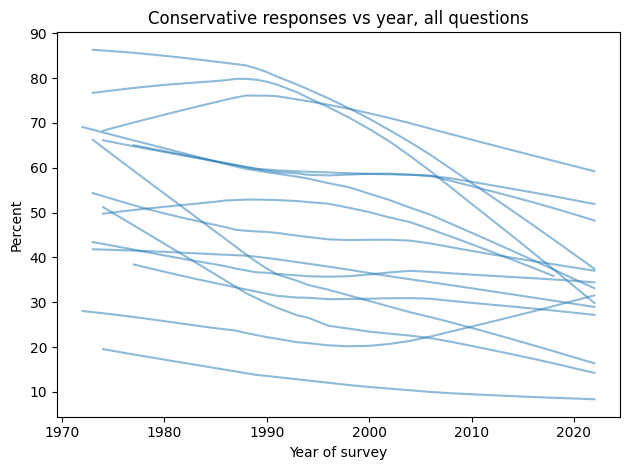

In [57]:
questions['year'] = gss['year']
over_time = questions.groupby("year").mean()

for column in over_time.columns:
    color = 'C0' if column == 'gunlaw' else 'C0'
    plot_series_lowess(over_time[column] * 100, color=color, ls="-", alpha=0.5)

decorate(
    xlabel="Year of survey",
    ylabel="Percent",
    title="Conservative responses vs year, all questions",
    legend=False,
)
plt.savefig('overton12.png', dpi=600)

The average number of conservative responses has decreased.
In 1973, the average respondent chose a conservative response to 8.1 out of 15 questions; in 2021, it had fallen to 5.3.

Also, contrary to what you might have heard, there is no evidence that this trend has slowed or reversed recently.
If anything, it might be accelerating.

To see whether this trend is driven primarily by period or cohort effects, consider the following graph, which shows conservatism grouped by decade of birth and plotted over time:

In [58]:
params = run_subgroups(gss, xvarname, yvarname, gvarname, yvalue)
params

,param,pvalue,stderr,conf_inf
all,-0.060046,0.000000e+00,0.000810,"[-0.0616338692030601, -0.05845832433589634]"
1890,0.006521,8.352848e-01,0.031339,"[-0.055111160407584917, 0.06815310292222276]"
1900,0.010204,3.482404e-01,0.010875,"[-0.011127785852057466, 0.031536033512160735]"
1910,-0.010026,8.696829e-02,0.005856,"[-0.021507623932094377, 0.0014555531383477743]"
1920,-0.012021,1.235455e-03,0.003719,"[-0.019312011107820964, -0.004730199677379041]"
1930,-0.020335,8.678576e-13,0.002838,"[-0.02589925330900738, -0.014771106787142057]"
1940,-0.013159,8.406666e-09,0.002283,"[-0.0176338405565886, -0.008685036147207037]"
1950,-0.014347,1.985560e-14,0.001873,"[-0.01801784232305387, -0.01067556706725568]"
1960,-0.025703,7.812367e-27,0.002390,"[-0.030387391596911083, -0.02101821559943505]"
1970,-0.019178,4.130724e-07,0.003784,"[-0.02659613821050341, -0.011759451161761476]"


In [59]:
summarize_params(params)

Number of groups 12
# neg, #pos 8 0


In [60]:
cohort_table = make_table(gss, xvarname, yvarname, gvarname, yvalue)

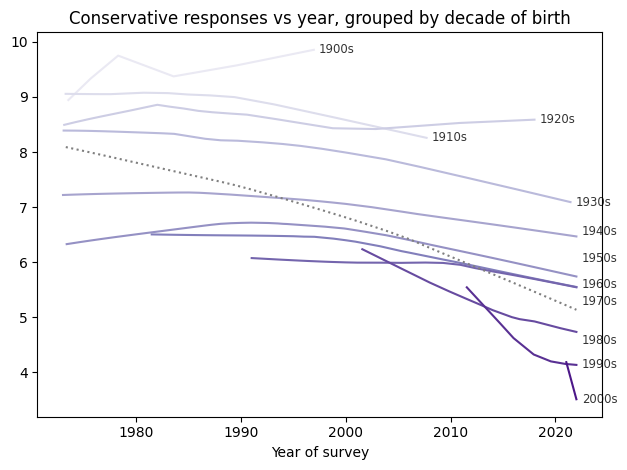

In [61]:
#figwidth = 3.835
#plt.figure(figsize=(figwidth, 0.5*figwidth))

visualize_table(series_conservatism, cohort_table)
nudge = {
    "1940s": 0.085,
    "1950s": 0.32,
    "1960s": 0.04,
    "1970s": -0.25,
    "1980s": -0.15,
}
label_table(cohort_table, nudge)

decorate(
    xlabel="Year of survey",
    title="Conservative responses vs year, grouped by decade of birth",
    legend=False,
)
plt.savefig("overton7.jpg", dpi=600)

There is clearly a cohort effect: almost every birth cohort is more liberal than the one before it.

In [62]:
(gss.query("year < 1980")["sexeduc"].dropna() == 2).mean()

0.19458467186782927

In [63]:
(gss.query("year >= 2010")["sexeduc"].dropna() == 2).mean()

0.0946515397082658

In [64]:
(gss.query("cohort10 > 1980")["sexeduc"].dropna() == 2).mean()

0.061620572537603106

If there is also period effect, we expect to see all groups moving up and down at the same time.
And it looks like they did: several cohorts trended toward conservative before 1990 and toward liberal after.
But the net change in most groups is small, so it seems like most of the change we've seen is due to the cohort effect, not the period effect.

To quantify that conclusion, we can run counterfactual models as we did in the previous chapter with attitudes toward homosexuality.
In that example, we found that the cohort effect accounted for about one third of the change, and the period effect the other two thirds.

The following figure shows the actual change in conservatism over the last 50 years and two counterfactual models: one with the period effect only and one with the cohort effect only.

In [65]:
data = pd.DataFrame(
    dict(
        y=gss["y"],
        cohort=gss["cohort"],
        year=gss["year"],
    )
)

data.tail()

,y,cohort,year
72385,4.134341,1990.0,2022
72386,4.886251,1993.0,2022
72387,8.791307,1970.0,2022
72388,7.653601,1939.0,2022
72389,4.230964,1967.0,2022


In [66]:
import statsmodels.formula.api as smf

formula = "y ~ year + cohort"
results = smf.ols(formula, data=data).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     5647.
Date:                Sat, 06 Jan 2024   Prob (F-statistic):               0.00
Time:                        08:57:45   Log-Likelihood:            -1.6237e+05
No. Observations:               64763   AIC:                         3.247e+05
Df Residuals:                   64760   BIC:                         3.248e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    133.6676      1.558     85.785      0.000     130.614     136.722
year          -0.0149      0.001    -14.968      0.000      -0.017      -0.013
cohort        -0.0497      0.001    -73.117      0.000      -0.051      -0.048
==============================================================================
Omnibus:                      811.905   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              528.215
Skew:                           0.080   Prob(JB):                    1.99e-115
Kurtosis:                       2.588   Cond. No.                     3.73e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.73e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [67]:
results.params["cohort"] / results.params["year"]

3.343188018682335

In [68]:
data["predict"] = results.predict(data)
pred = data.groupby("year")["predict"].mean()

In [69]:
y = 1972
c = data.query("year==1972")["cohort"].mean()
b0, b1, b2 = results.params

In [70]:
from utils import make_counterfact

inter = b0 + b1 * y
cohort_only = make_counterfact(results, "year", inter, data)

In [71]:
def error_func(inter):
    period_only = make_counterfact(results, "cohort", inter, data)
    return period_only[y] - pred[y]

g0 = b0 + b2 * c
error_func(g0)

7.105427357601002e-15

In [72]:
# g0 = b0 + b2 * c
# inter = fsolve(error_func, g0)
inter = g0
period_only = make_counterfact(results, "cohort", inter, data)

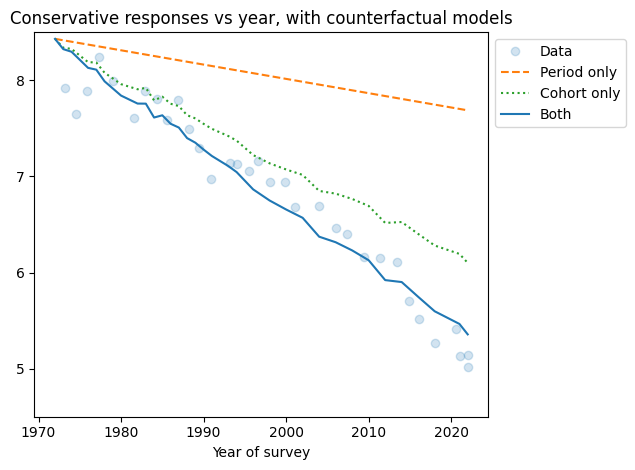

In [73]:
series_conservatism.plot(style="o", color="C0", alpha=0.2, label="Data")
period_only.plot(ls="--", color="C1", label="Period only")
cohort_only.plot(ls=":", color="C2", label="Cohort only")
pred.plot(color="C0", label="Both")

decorate(
    xlabel="Year of survey",
    title="Conservative responses vs year, with counterfactual models",
    ylim=[4.5, 8.5]
)
plt.yticks([5, 6, 7, 8])
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.savefig("overton8.jpg", dpi=600)

The the cohort effect is about five times bigger than the period effect, which means that the observed changes are due primarily to generational replacement, and only secondarily to changed minds.

## Everything is Relative

So again, if people are actually becoming more liberal, why do they think they are getting more conservative?

The second part of the explanation is that people classify their political views relative to the perceived center.
As evidence, consider the following figure, which shows the percentage of people who identify as moderate, conservative, or liberal over time.

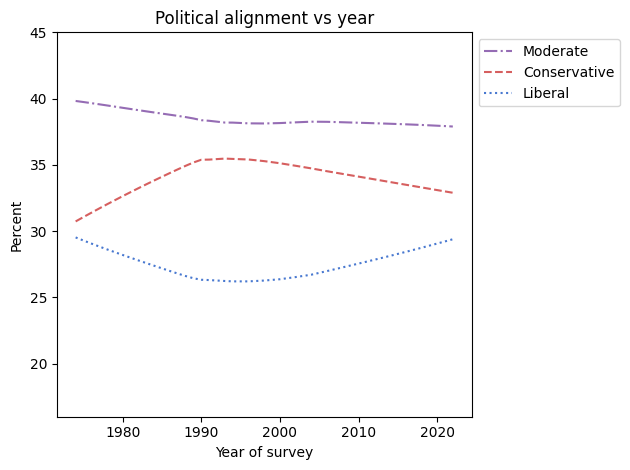

In [74]:
xtab = pd.crosstab(gss["year"], gss["polviews3"], normalize="index") * 100

columns = ["Moderate", "Conservative", "Liberal"]
for column in columns:
    plot_series_lowess(
        xtab[column], ls=line_map[column], color=polview_map[column], **options
    )

decorate(
    xlabel="Year of survey",
    title="Political alignment vs year",
    ylabel="Percent",
    ylim=[16, 45]
)
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.savefig("overton9.jpg", dpi=600)

The percentage of people who identify as "Moderate" has barely changed in 50 years.

During the 1980s, the percentage of conservatives increased and the percentage of liberals declined.
I conjecture that these changes are the result of negative connotations that were assigned to the word "liberal" during the Reagan Era.
Many left-of-center politicians avoided using the word for decades; GSS respondents might have been reluctant to identify with the word, even if their views were actually left of center.

Despite all that, the responses are remarkably stable over time.
These results suggest that the label people choose for themselves depends primarily on how they compare their views to the center of public opinion, and maybe secondarily on the connotations of the labels.

## Are we more polarized?

The third part of the explanation is that conservatives, moderates, and liberals have all become more liberal over time.
In current commentary, it is often taken for granted that politics in the U.S. have become more polarized.
If we take that to mean that conservatives are becoming more conservative, and liberals more liberal, that turns out not to be true.

The following figure shows conservatism over time, grouped by political alignment.

In [75]:
params = run_subgroups(gss, "year", "conservatism", "polviews3", "continuous")
params

,param,pvalue,stderr,conf_inf
all,-0.060046,0.000000e+00,0.000810,"[-0.0616338692030601, -0.05845832433589634]"
Conservative,-0.036411,2.112215e-142,0.001422,"[-0.03919825644645624, -0.03362424192561849]"
Liberal,-0.076986,0.000000e+00,0.001502,"[-0.07993025014500976, -0.07404260497230425]"
Moderate,-0.066705,0.000000e+00,0.001244,"[-0.06914408750464808, -0.06426599477729385]"


In [76]:
table = gss.pivot_table(index="year", columns="polviews3", values="conservatism")

In [77]:
con = make_lowess(table['Conservative'])
lib = make_lowess(table['Liberal'])
diff = con - lib
diff[1974], diff[2021]

(2.4730099087783772, 3.8937716805319544)

In [78]:
for column, series in table.items():
    smooth = make_lowess(series)
    diff = smooth.iloc[-1] - smooth.iloc[1]
    print(column, diff)

Conservative -1.9355466630545317
Liberal -3.4266655507829293
Moderate -3.2730804048192903


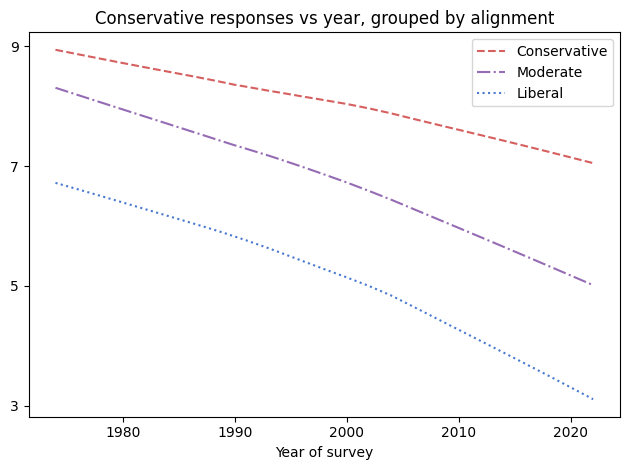

In [79]:
columns = ["Conservative", "Moderate", "Liberal"]
for column in columns:
    plot_series_lowess(
        table[column], ls=line_map[column], color=polview_map[column], **options
    )

decorate(
    xlabel="Year of survey",
    title="Conservative responses vs year, grouped by alignment",
)
plt.yticks([3, 5, 7, 9])
plt.savefig("overton10a.jpg", dpi=600)

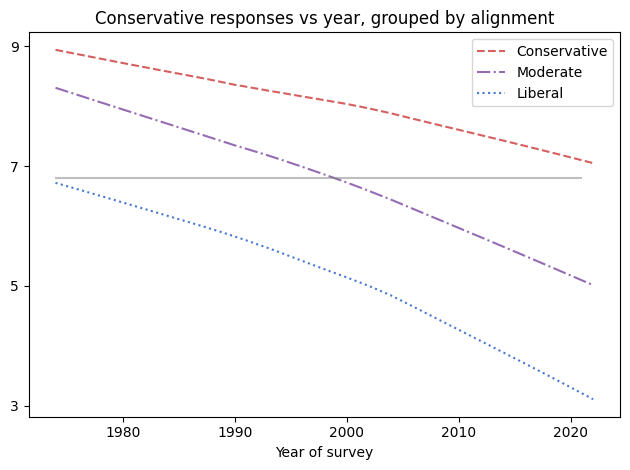

In [80]:
columns = ["Conservative", "Moderate", "Liberal"]
for column in columns:
    plot_series_lowess(
        table[column], ls=line_map[column], color=polview_map[column], **options
    )

plt.hlines(6.8, 1974, 2021, color="gray", alpha=0.5)
decorate(
    xlabel="Year of survey", 
    title="Conservative responses vs year, grouped by alignment",
)
plt.yticks([3, 5, 7, 9])
plt.savefig("overton10b.jpg", dpi=600)

All three groups have become more liberal; however, the slopes of the lines are somewhat different.
Over this interval, conservatives have become more liberal by about 1.9 responses, on average, moderates by 3.2, and liberals by 3.4.
That's a kind of polarization in the sense that the groups moved farther apart, but not in the sense that they are moving in opposite directions.

Also, the magnitude of the divergence is modest.
If civil discourse was possible in 1973, when conservatives and liberals disagreed about 2.5 questions, on average, it should be possible now, when they disagree about 3.7.

## Chasing Overton

Now we are ready to put the pieces of the explanation together.
In the previous figure, the horizontal line is at 6.8 responses, which was the expected level of conservatism in 1974 among people who called themselves liberal.

Suppose you take a time machine back to 1974, find an average liberal, and bring them to the turn of the millennium.
Based on their responses to the fifteen questions, they would be indistinguishable from the average moderate in 2000.
And if you bring them to 2021, their quaint 1970s liberalism would be almost as conservative as the average conservative.

In 1974, they were left of center, and would probably identify as liberal.
In 2021, they would find themselves considerably right of center, and would probably identify as conservative.

In [81]:
make_lowess(table["Moderate"])[2000]

6.761093967503579

In [82]:
make_lowess(table["Conservative"])[2021]

6.985503511703538

This time machine scenario is almost precisely what happened to people born in the 1940s.
The following figure is the same as the previous one, except that the solid line shows average conservatism for people born in the 1940s.

In [83]:
def plot_overton(cohort_table, cohort):
    """Plot conservative responses by year, grouped by alignment.
    """
    columns = ["Conservative", "Moderate", "Liberal"]
    for column in columns:
        plot_series_lowess(
            table[column], ls=line_map[column], color=polview_map[column], **options
        )

    plot_series_lowess(cohort_table[cohort], color="gray", alpha=0.5, label=f"{cohort}s")
    decorate(
        xlabel="Year of survey", title="Conservative responses vs year, grouped by alignment"
    )

In [84]:
table = gss.pivot_table(index="year", columns="polviews3", values="conservatism")

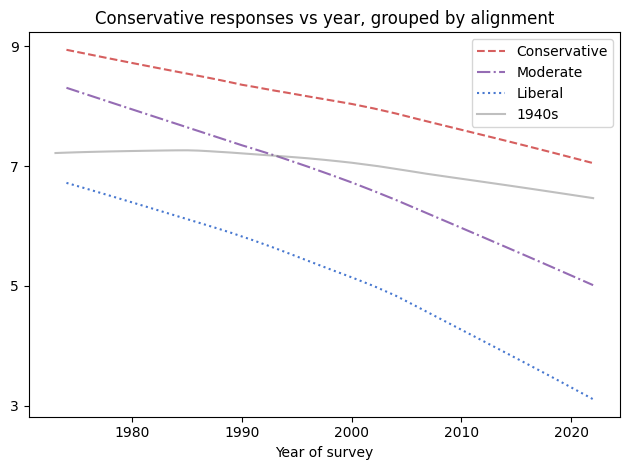

In [85]:
plot_overton(cohort_table, cohort=1940)
plt.yticks([3, 5, 7, 9])
plt.savefig("overton11.jpg", dpi=600)

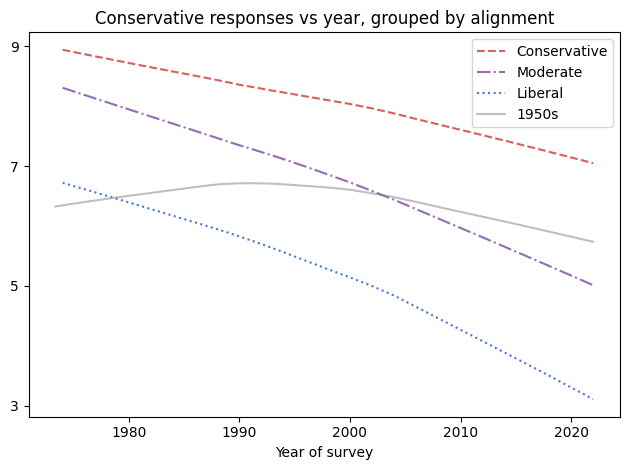

In [86]:
plot_overton(cohort_table, cohort=1950)
plt.yticks([3, 5, 7, 9])
plt.savefig("overton11a.jpg", dpi=600)

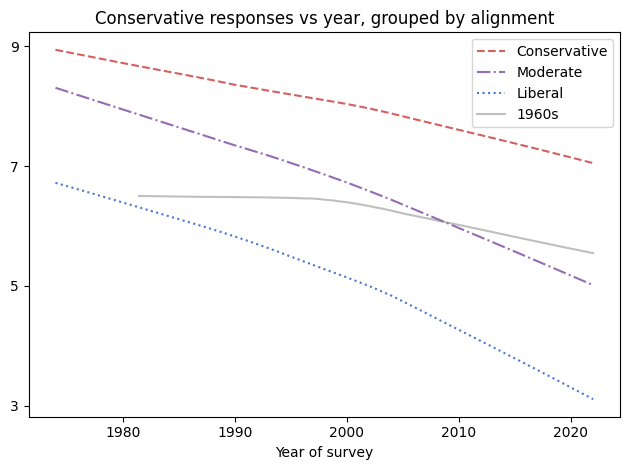

In [87]:
plot_overton(cohort_table, cohort=1960)
plt.yticks([3, 5, 7, 9])
plt.savefig("overton11b.jpg", dpi=600)

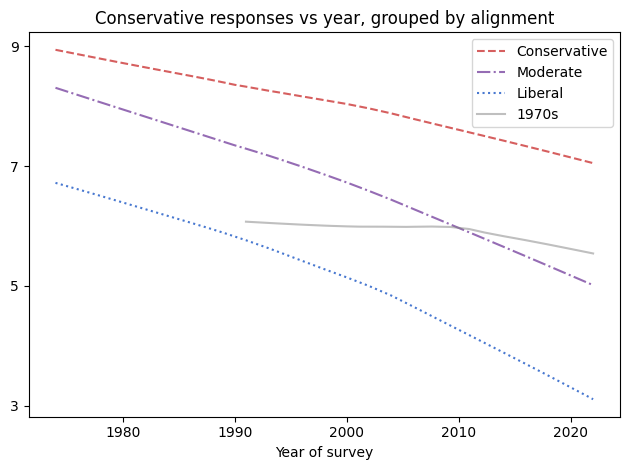

In [88]:
plot_overton(cohort_table, cohort=1970)
plt.yticks([3, 5, 7, 9])
plt.savefig("overton11c.jpg", dpi=600)

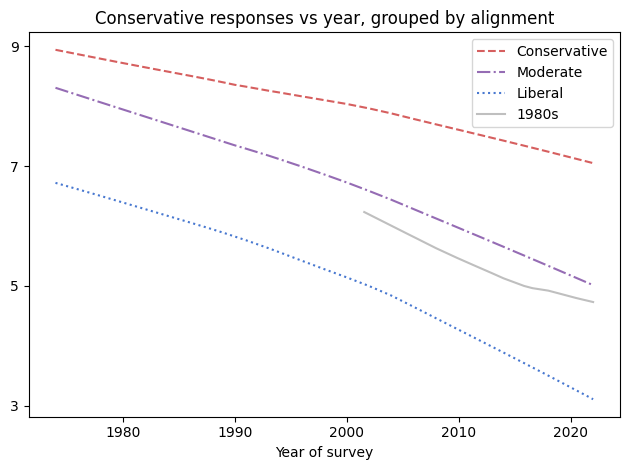

In [89]:
plot_overton(cohort_table, cohort=1980)
plt.yticks([3, 5, 7, 9])
plt.savefig("overton11d.jpg", dpi=600)

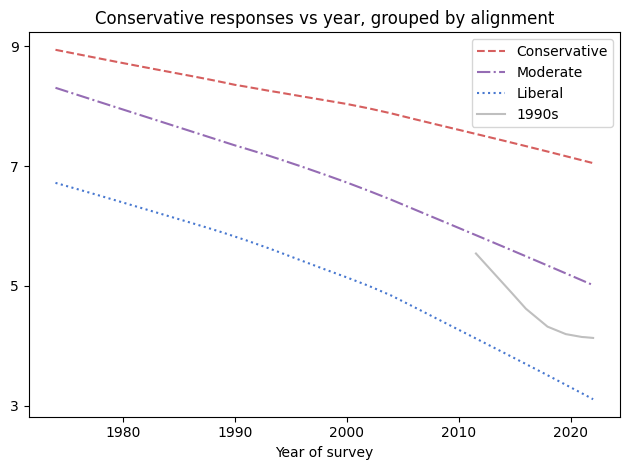

In [90]:
plot_overton(cohort_table, cohort=1990)
plt.yticks([3, 5, 7, 9])
plt.savefig("overton11e.jpg", dpi=600)

In the 1970s, when they were in their 30s, they were almost as liberal, on average, as the people who identified as liberal.

Over their lives, they trended toward conservative until 1990, reversed toward liberal after, and ended up a little left of where they started.
Meanwhile, the world around them changed.

In the 1990s, when they were in their 50s, they became indistinguishable from the people around them who identified as moderate.

And in the 2010s, when they were in their 70s, they found -- to their surprise and often dismay -- that they were almost as conservative, on average, as people who identified as conservative.

Abe Simpson, the grandfather on *The Simpsons*, summed up their plight:

> I used to be with ‘it’, but then they changed what ‘it’ was. Now what I’m with isn’t ‘it’  and what’s ‘it’ seems weird and scary to me. It’ll happen to you!

He's right.
Unless your views move faster than the Overton window -- and for most people they don't -- you will go to bed one night thinking you're with 'it', and the next day you'll wake up on the wrong side of history.

## Sources and related reading

In many chapters, I started with analysis from a published article and then replicated or extended it.
This chapter is a little different because it is mostly about my own investigation using data from the General Social Survey.
As a result, I have fewer sources to cite and less related reading to recommend.

Also, it would be appropriate to consider the results in this chapter an initial exploration by a data scientist, intended to demonstrate certain tools and concepts, not definitive research by experts in political science.

* Quote Investigator explores the origin of the unattributable quote \cite{otoole2014}.

* The General Social Survey (GSS) is a project of the independent research organization NORC at the University of Chicago, with principal funding from the National Science Foundation. The data is available from the GSS website \cite{gss2022}.

* An article in *The Chicago Tribune* discusses social attitudes toward the word "liberal" \cite{page2007}.

## Appendix: The Fifteen Questions

This appendix provides the wording of the fifteen questions from the General Social Survey that most distinguish liberals and conservatives, identified by topic and the GSS code name.

* Homosexuality (homosex): What about sexual relations between two adults of the same sex--do you think it is always wrong, almost always wrong, wrong only sometimes, or not wrong at all?

* Capital punishment (cappun): Do you favor or oppose the death penalty for persons convicted of murder?

* Legal cannabis (grass): Do you think the use of marijuana should be made legal or not?

* Abortion (abany): Please tell me whether or not you think it should be possible for a pregnant woman to obtain a legal abortion if the woman wants it for any reason?

* Prayer in public schools (prayer): The United States Supreme Court has ruled that no state or local government may require the reading of the Lord's Prayer or Bible verses in public schools. What are your views on this--do you approve or disapprove of the court ruling?

* Premarital sex (premarsx): There's been a lot of discussion about the way morals and attitudes about sex are changing in this country. If a man and woman have sex relations before marriage, do you think it is always wrong, almost always wrong, wrong only sometimes, or not wrong at all?

* Divorce (divlaw): Should divorce in this country be easier or more difficult to obtain than it is now?

* Spending on welfare (natfare) and improving and protecting the environment (natenvir): We are faced with many problems in this country, none of which can be solved easily or inexpensively. I'm going to name some of these problems, and for each one I'd like you to tell me whether you think we're spending too much money on it, too little money, or about the right amount.

* Pornography (pornlaw): Which of these statements comes closest to your feelings about pornography laws? 

    * There should be laws against the distribution of pornography whatever the age.

    * There should be laws against the distribution of pornography to persons under 18.

    * There should be no laws forbidding the distribution of pornography.

* Open housing law (racopen): Suppose there is a community-wide vote on the general housing issue. There are two possible laws to vote on; which law would you vote for? 

    * One law says that a homeowner can decide for himself whom to sell his house to, even if he prefers not to sell to [people of a particular race].

    * The second law says that a homeowner cannot refuse to sell to someone because of their race or color.

* Assisted suicide (letdie1): When a person has a disease that cannot be cured, do you think doctors should be allowed by law to end the patient's life by some painless means if the patient and his family request it?

* Women in politics (fepol): Tell me if you agree or disagree with this statement:  Most men are better suited emotionally for politics than are most women.

* Gun control (gunlaw): Would you favor or oppose a law which would require a person to obtain a police permit before he or she could buy a gun?

* Sex education (sexeduc): Would you be for or against sex education in the public schools?

Probably Overthinking It

Copyright 2022 Allen Downey 

The code in this notebook and `utils.py` is under the [MIT license](https://mit-license.org/).